# Chapter 9: Analysis of Chemical Reactions

## 9.2. Reaction Mechanism Analysis

In the following section, we will investigate the mechanism of an $S_{N}2$ reaction between chloride and methyl bromide:

### 9.2.1. Calculation of Potential Energy of Reactants and Products

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from utils import View3DModel, AddBonds, WriteXYZString, ReadXYZString, WritePDBTrajectory
import psi4
import py3Dmol
import fortecubeview
from tqdm import tqdm

In [2]:
# Set the number of threads and memory limit
psi4.set_num_threads(16)
psi4.set_memory(16*1024*1024*1024) # 16 GB

17179869184

In [3]:
# Set calculation options
psi4.set_options({
    'BASIS': '6-31G*',
    'SCF_TYPE': 'DF',
    'REFERENCE': 'RHF'
})

First, we calculate the energy of compounds:

In [4]:
# Define a function that calculate the potential energy of individual molecule
def calculate_potential_energy(mol, charge, multiplicity, optimization=True):
    # Write the geometry to XYZ string
    xyz_string = WriteXYZString(mol, charge, multiplicity)

    # Get the psi4 geometry
    geometry = psi4.geometry(xyz_string)
    
    if optimization:
        # Perform geometry optimization
        energy = psi4.optimize('b3lyp', molecule=geometry)
    else:
        # Perform single-point calculation
        energy = psi4.energy('b3lyp', molecule=geometry)
    
    return geometry, energy * psi4.constants.hartree2kcalmol

In [5]:
# Create a molecule of the substrate (methyl bromide)
substrate_mol = Chem.MolFromSmiles('CBr')

# Prepare the molecule
substrate_mol = Chem.AddHs(substrate_mol)
AllChem.EmbedMolecule(substrate_mol, useRandomCoords=True)
AllChem.UFFOptimizeMolecule(substrate_mol, maxIters=200)

0

In [6]:
# Create a molecule of the nucleophile (methoxide)
nu_mol = Chem.MolFromSmiles('[Cl-]')

# Prepare the molecule
nu_mol = Chem.AddHs(nu_mol)
AllChem.EmbedMolecule(nu_mol, useRandomCoords=True)
AllChem.UFFOptimizeMolecule(nu_mol, maxIters=200)

0

In [7]:
# Create a molecule of the product (methyl chloride)
product_mol = Chem.MolFromSmiles('CCl')

# Prepare the molecule
product_mol = Chem.AddHs(product_mol)
AllChem.EmbedMolecule(product_mol, useRandomCoords=True)
AllChem.UFFOptimizeMolecule(product_mol, maxIters=200)

0

In [8]:
# Create a molecule of the leaving group (chloride)
lg_mol = Chem.MolFromSmiles('[Br-]')

# Prepare the molecule
lg_mol = Chem.AddHs(lg_mol)
AllChem.EmbedMolecule(lg_mol, useRandomCoords=True)
AllChem.UFFOptimizeMolecule(lg_mol, maxIters=200)

0

In [9]:
# Calculate the potential energy of the substrate
charge = 0
multiplicity = 1
substrate_geo, substrate_energy = calculate_potential_energy(substrate_mol, charge, multiplicity)
print(substrate_energy)

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 4.17e-07



Optimizer: Optimization complete!
-1640097.1768382087


In [10]:
# View the optimized geometry
substrate_mol_optimized = ReadXYZString(substrate_geo.save_string_xyz())
View3DModel(substrate_mol_optimized)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# Calculate the potential energy of the nucleophile
charge = -1
multiplicity = 1
nu_geo, nu_energy = calculate_potential_energy(nu_mol, charge, multiplicity, False)
print(nu_energy)

-288812.63745103026


In [12]:
# Calculate potential energy of the product
charge = 0
multiplicity = 1
product_geo, product_energy = calculate_potential_energy(product_mol, charge, multiplicity)
print(product_energy)

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 2.92e-07



Optimizer: Optimization complete!
-313822.86577274796


In [13]:
# View the optimized geometry
product_mol_optimized = ReadXYZString(product_geo.save_string_xyz())
View3DModel(product_mol_optimized)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
# Calculate potential energy of the leaving group
charge = -1
multiplicity = 1
lg_geo, lg_energy = calculate_potential_energy(lg_mol, charge, multiplicity, optimization=False)
print(lg_energy)

-1615099.0703239436


Althought the potential energies of individual molecules were calculated, we should keep in mind that when molecule are close to each other, they can interact, leading the changes in potential energy. Therefore, we must combine them into one geometry and calculate the energy of that system:

In [15]:
# Combine the substrate and the nucleophile into 1 molecule object
substrate_nu_mol = Chem.CombineMols(substrate_mol, nu_mol)

# Get the indices of atoms
for atom in substrate_nu_mol.GetAtoms():
    print([atom.GetSymbol(), atom.GetIdx()])

['C', 0]
['Br', 1]
['H', 2]
['H', 3]
['H', 4]
['Cl', 5]


In [16]:
# Make a copy to modify the molecule
substrate_nu_mol_copy = Chem.RWMol(substrate_nu_mol)

# Temporarily remove C-H bond and add C-Cl bond
substrate_nu_mol_copy.RemoveBond(0, 2)
substrate_nu_mol_copy.AddBond(0, 5)
Chem.SanitizeMol(substrate_nu_mol_copy)

# Align the Cl atom with the C-Br bond
Chem.rdMolTransforms.SetAngleDeg(substrate_nu_mol_copy.GetConformer(), 1, 0, 5, 180)

# Set the C-Cl bond length (~ 4 angstrom)
Chem.rdMolTransforms.SetBondLength(substrate_nu_mol_copy.GetConformer(), 0, 5, 4)

# Remove C-Cl bond and add C-H bond back
substrate_nu_mol_copy.RemoveBond(0, 5)
substrate_nu_mol_copy.AddBond(0, 2)
Chem.SanitizeMol(substrate_nu_mol_copy)

# Convert back to regular molecule object
substrate_nu_mol = substrate_nu_mol_copy.GetMol()

# View 3D model
View3DModel(substrate_nu_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
# Write the geometry to XYZ string
charge = -1
multiplicity = 1
xyz_string = WriteXYZString(substrate_nu_mol, charge, multiplicity)

# Get the psi4 geometry
substrate_nu_geo = psi4.geometry(xyz_string)

# Optimize the geometry of the substrate and nucleophile
substrate_nu_energy = psi4.optimize('b3lyp', molecule=substrate_nu_geo)
substrate_nu_energy *= psi4.constants.hartree2kcalmol
print(substrate_nu_energy)

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 4.04e-06

	Unable to completely converge to displaced geometry.
	RMS(dx):  2.095e-06 	Max(dx):  4.087e-06 	RMS(dq):  2.859e-04
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 2.86e-04

	Change in internal coordinate of 6.75e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Unable to completely converge to displaced geometry.
	RMS(dx):  3.703e-06 	Max(dx):  6.905e-06 	RMS(dq):  1.233e-04
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.23e-04

	Change in internal coordinate of 6.78e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 1.35e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Unable to completely converge to displaced geometry.
	RMS

Optimizer: Optimization complete!
-1928923.574903594


In [18]:
# View the optimized geometry
View3DModel(ReadXYZString(substrate_nu_geo.save_string_xyz()))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:
# Combine the product and the leaving group into 1 molecule object
product_lg_mol = Chem.CombineMols(product_mol, lg_mol)

# Get the indices of atoms
for atom in product_lg_mol.GetAtoms():
    print([atom.GetSymbol(), atom.GetIdx()])

['C', 0]
['Cl', 1]
['H', 2]
['H', 3]
['H', 4]
['Br', 5]


In [20]:
# Make a copy to modify the molecule
product_lg_mol_copy = Chem.RWMol(product_lg_mol)

# Temporarily remove C-H bond and add C-Br bond
product_lg_mol_copy.RemoveBond(0, 2)
product_lg_mol_copy.AddBond(0, 5)
Chem.SanitizeMol(product_lg_mol_copy)

# Align the Br atom with the C-Cl bond
Chem.rdMolTransforms.SetAngleDeg(product_lg_mol_copy.GetConformer(), 1, 0, 5, 180)

# Set the C-Br bond length (~ 4 angstrom)
Chem.rdMolTransforms.SetBondLength(product_lg_mol_copy.GetConformer(), 0, 5, 4)

# Remove C-Br bond and add C-H bond back
product_lg_mol_copy.RemoveBond(0, 5)
product_lg_mol_copy.AddBond(0, 2)
Chem.SanitizeMol(product_lg_mol_copy)

# Convert back to regular molecule object
product_lg_mol = product_lg_mol_copy.GetMol()

# View 3D model
View3DModel(product_lg_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
# Write the geometry to XYZ string
charge = -1
multiplicity = 1
xyz_string = WriteXYZString(product_lg_mol, charge, multiplicity)

# Get the psi4 geometry
product_lg_geo = psi4.geometry(xyz_string)

# Optimize the geometry of the substrate and nucleophile
product_lg_energy = psi4.optimize('b3lyp', molecule=product_lg_geo)
product_lg_energy *= psi4.constants.hartree2kcalmol
print(product_lg_energy)

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.99e-05

	Change in internal coordinate of 7.63e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 5.11e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 1.00e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Unable to completely converge to displaced geometry.
	RMS(dx):  3.467e-06 	Max(dx):  7.482e-06 	RMS(dq):  2.095e-06
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.88e-06

	Change in internal coordinate of 6.88e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Change in internal coordinate of 9.60e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to 2.500e-01.
	Change

Optimizer: Optimization complete!
-1928931.8093019857


In [22]:
# View the optimized geometry
View3DModel(ReadXYZString(product_lg_geo.save_string_xyz()))

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 9.2.2. Calculation of Potential Energy of Transition State

First, we have to guess the geometry of the transition state ($TS^{\ddagger}$), we can do it using Avogadro or other software:

For example, our initial guess of the $TS^{\ddagger}$ is in the file `SN2_TS.xyz`.

In [23]:
# Load the geometry from the file
ts_guess_mol = Chem.MolFromXYZFile('.\\structures\\SN2_TS.xyz')
ts_guess_mol = AddBonds(ts_guess_mol, 1.5)

# View the initial guess
View3DModel(ts_guess_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
# Find the indices of atoms
for atom in ts_guess_mol.GetAtoms():
    print([atom.GetSymbol(), atom.GetIdx()])

['H', 0]
['H', 1]
['H', 2]
['C', 3]
['Cl', 4]
['Br', 5]


In [25]:
# Set the atom indices
C_idx = 3
Cl_idx = 4
Br_idx = 5
H1_idx = 0
H2_idx = 1
H3_idx = 2

Next, we optimize our guess geometry to the true $TS^{\ddagger}$ geometry. A $TS^{\ddagger}$ is a saddle point on the PES, therefore, it should have exactly one imaginary vibrational frequency. We will do a frequency analysis after geometry optimization to confirm.

In [26]:
# Generate the xyz string
charge = -1
multiplicity = 1
xyz_string = WriteXYZString(ts_guess_mol, charge, multiplicity)

# Get the psi4 geometry
ts_geometry = psi4.geometry(xyz_string)

In [27]:
# Set optimization parameters
max_iters = 500
psi4.set_options({'OPT_TYPE': 'TS'})
psi4.set_options({'OPT_COORDINATES': 'CARTESIAN'})
psi4.set_options({'FULL_HESS_EVERY': 0})
psi4.set_options({'GEOM_MAXITER': max_iters})
psi4.set_options({'G_CONVERGENCE': 'GAU_LOOSE'})

In [28]:
# Freeze the position of atoms (optional)
psi4.set_options({'FROZEN_CARTESIAN': f'{H1_idx + 1} xyz\n{H2_idx + 1} xyz\n{H3_idx + 1} xyz'}) # Free the 3 H atoms

# Freeze the bond lengths (optional)
psi4.set_options({'FROZEN_DISTANCE': ''})

# Freeze the bond angles (optional)
psi4.set_options({'FROZEN_BEND': ''})

In [29]:
# Run geometry optimization
ts_energy, ts_history = psi4.optimize('b3lyp', molecule=ts_geometry, optking__geom_maxiter=max_iters, return_history=True)
ts_energy *= psi4.constants.hartree2kcalmol
print(ts_energy)

	Change in internal coordinate of 7.31e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 6.87e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Change in internal coordinate of 1.07e+00 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 5.98e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 6.41e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 4.
	Change in internal coordinate of 6.25e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 3.
	Change in internal coordinate of 6.23e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 2.
	Change in internal coordinate of 6.67e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 6.90e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 5.
	Change in internal coordinate of 8.4

Optimizer: Optimization complete!
-1928876.865778752


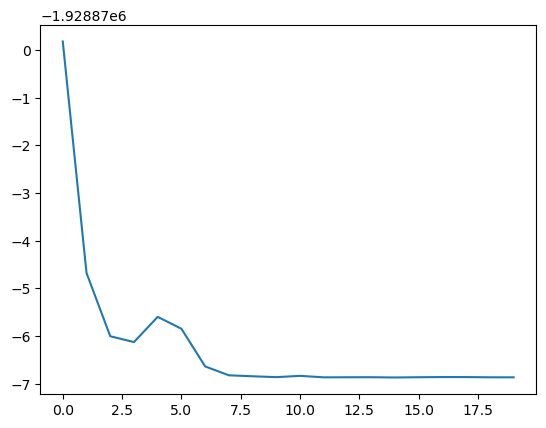

In [30]:
# Plot the energy diagram of the optimization process
ts_energies = ts_history['energy'] 
ts_energies = np.array(ts_energies) * psi4.constants.hartree2kcalmol
plt.plot(ts_energies)

In [31]:
# Get the optimized geometry as xyz string
optimized_ts_xyz_string = ts_geometry.save_string_xyz()

# Get optimized TS molecule
ts_optimized_mol = ReadXYZString(optimized_ts_xyz_string)

# View the 3D model
View3DModel(ts_optimized_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
# You can also write the optimized TS geometry to a file
xyz_file_name = 'SN2_TS_optimized.xyz'
xyz_file = open(f'.\\structures\\{xyz_file_name}', 'w')
xyz_file.write(optimized_ts_xyz_string)
xyz_file.close()

In [33]:
# Load the optimized TS geometry from a file
xyz_file_name = 'SN2_TS_optimized_gaussian.xyz'
xyz_file = open(f'.\\structures\\{xyz_file_name}', 'r')
optimized_ts_xyz_string = xyz_file.read()
xyz_file.close()

# Get optimized TS molecule
ts_optimized_mol = ReadXYZString(optimized_ts_xyz_string)

# View the 3D model
View3DModel(ts_optimized_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [34]:
# Recalculate the potential energy of the TS
ts_geometry = psi4.geometry(optimized_ts_xyz_string)
ts_energy = psi4.energy('b3lyp', molecule=ts_geometry, return_wfn=True)
ts_energy = ts_energy[0] * psi4.constants.hartree2kcalmol

In [35]:
# Run frequency analysis
energy, wfn = psi4.frequencies('b3lyp', molecule=ts_geometry, return_wfn=True)

In [36]:
# Extract frequencies and intensities
frequencies = wfn.frequencies().to_array()

# Print out the vibrational frequencies to check for imaginary frequencies
print(frequencies)

[-315.34315778  176.05418073  176.93250662  179.40926728  906.99924106
  908.89551706  999.32180810 1420.77571561 1422.72200206 3247.60531946
 3442.45597690 3446.11718633]


### 9.2.3. Reaction Energy Diagram

Knowing the potential energy of the $TS^{\ddagger}$, we can plot the energy diagram for this reaction:

In [37]:
# Get the energy levels for reactants, TS, and products
e_reactants_separate = substrate_energy + nu_energy
e_reactants_close = substrate_nu_energy
e_ts = ts_energy
e_products_close = product_lg_energy
e_products_separate = product_energy + lg_energy

In [38]:
# If we set e_reactants_close as the reference point (E = 0), we can calculate the relative energies
e_reactants_separate -= e_reactants_close
e_ts -= e_reactants_close
e_products_close -= e_reactants_close
e_products_separate -= e_reactants_close
e_reactants_close = 0

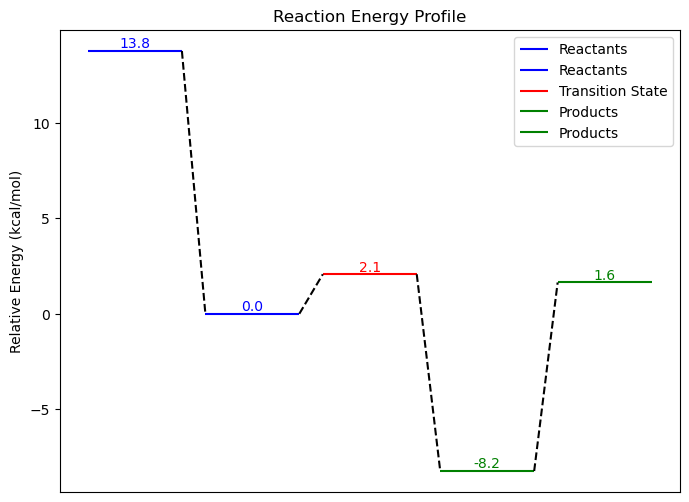

In [39]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plotting horizontal lines for each energy state
plt.hlines(y=e_reactants_separate, xmin=0, xmax=0.4, color='blue', label='Reactants')
plt.hlines(y=e_reactants_close, xmin=0.5, xmax=0.9, color='blue', label='Reactants')
plt.hlines(y=e_ts, xmin=1, xmax=1.4, color='red', label='Transition State')
plt.hlines(y=e_products_close, xmin=1.5, xmax=1.9, color='green', label='Products')
plt.hlines(y=e_products_separate, xmin=2, xmax=2.4, color='green', label='Products')

# Connecting the energy levels with dotted lines
plt.plot([0.4, 0.5], [e_reactants_separate, e_reactants_close], 'k--')
plt.plot([0.9, 1], [e_reactants_close, e_ts], 'k--')
plt.plot([1.4, 1.5], [e_ts, e_products_close], 'k--')
plt.plot([1.9, 2], [e_products_close, e_products_separate], 'k--')

# Adding energy values on top of the lines
plt.text(0.2, e_reactants_separate, f'{e_reactants_separate:.1f}', ha='center', va='bottom', color='blue')
plt.text(0.7, e_reactants_close, f'{e_reactants_close:.1f}', ha='center', va='bottom', color='blue')
plt.text(1.2, e_ts, f'{e_ts:.1f}', ha='center', va='bottom', color='red')
plt.text(1.7, e_products_close, f'{e_products_close:.1f}', ha='center', va='bottom', color='green')
plt.text(2.2, e_products_separate, f'{e_products_separate:.1f}', ha='center', va='bottom', color='green')

# Adding titles, labels, and legend
plt.title('Reaction Energy Profile')
plt.ylabel('Relative Energy (kcal/mol)')
plt.xticks([])
plt.legend()

# Show the plot
plt.show()

From this diagram, we can also get the activation energy of this reaction:

In [40]:
# Calculate activation energy
E_a = ts_energy - substrate_nu_energy
print(f'Activation energy: {E_a} kcal/mol')

Activation energy: 2.0684453200083226 kcal/mol


### 9.2.4. Intrinsic Reaction Coordinate (IRC) Scan

An Intrinsic Reaction Coordinate (IRC) scan is a computational technique used in theoretical chemistry to map out the minimum energy pathway of a chemical reaction from reactants to products via the transition state. This concept is crucial for understanding how a reaction progresses at the molecular level.

In the section, we will perform IRC scan, both forward and backward, for this reaction:

***Forward IRC Scan***

In [41]:
# Set optimization parameters
max_iters = 100
psi4.set_options({'OPT_TYPE': 'IRC'})
psi4.set_options({'OPT_COORDINATES': 'CARTESIAN'})
psi4.set_options({'GEOM_MAXITER': max_iters})
psi4.set_options({'FULL_HESS_EVERY': 10})
psi4.set_options({'MAX_DISP_G_CONVERGENCE': 6.0e-6, 'RMS_DISP_G_CONVERGENCE': 4.0e-6})

In [42]:
irc_forward_geometry = psi4.geometry(optimized_ts_xyz_string)

# Run forward IRC scan
psi4.set_options({'IRC_POINTS': 10})
psi4.set_options({'IRC_DIRECTION': 'FORWARD'})
irc_forward_energy, irc_forward_history = psi4.optimize('b3lyp', molecule=irc_forward_geometry, return_history=True)

	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 2.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 4.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 5.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 6.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 5.


	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 7.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 8.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 7.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 9.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 10.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 9.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 11.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 12.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 11.


	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 14.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 15.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 14.
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 17.
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 18.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 17.
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scala

C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 23.


Optimizer: Optimization complete!
[{'step_number': 0, 'q': [-2.025786406490792, 1.6500601620597726, 0.0, 1.012893203245396, 1.6500601620597726, 1.7555555705503225, 1.012893203245396, 1.6500601620597726, -1.7555555705503225, 0.0, 1.6651779710634353, 0.0, 0.0, 6.134380257771198, 0.0, 0.0, -3.0345709029501835, 0.0], 'x': [[-2.025786406490792, 1.6500601620597726, 0.0], [1.012893203245396, 1.6500601620597726, 1.7555555705503225], [1.012893203245396, 1.6500601620597726, -1.7555555705503225], [0.0, 1.6651779710634353, 0.0], [0.0, 6.134380257771198, 0.0], [0.0, -3.0345709029501835, 0.0]], 'f_q': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00034162883118290025, 0.005863570343013594, 0.0, -3.1193953129790533e-06, -0.0020126174771291916, 0.0, -3.4433387745021694e-06, -0.004901829854836302, 0.0], 'f_x': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00034162883118290025, 0.005863570343013594, 0.0, -3.1193953129790533e-06, -0.0020126174771291916, 0.0, -3.4433387745021694e-06, -0.00490182985483

C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2


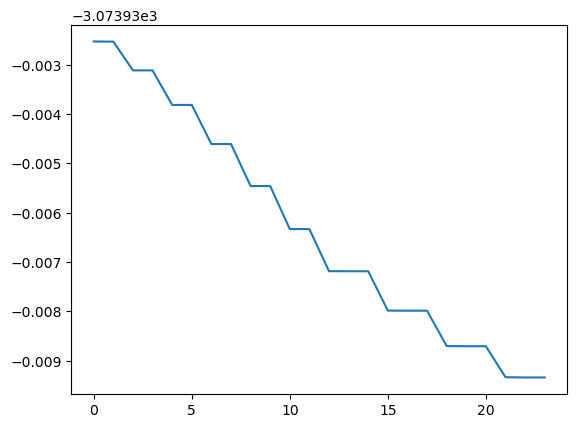

In [43]:
# Plot the energy values of forward IRC scan
irc_forward_energies = irc_forward_history['energy']
plt.plot(irc_forward_energies)

In [44]:
# Get the list of coordinates
irc_forward_coordinates_list = irc_forward_history['coordinates']

# Get the number of conformers
print(len(irc_forward_coordinates_list))

24


In [45]:
# Generate the PDB trajectory string
pdb_trajectory = WritePDBTrajectory(ts_optimized_mol, irc_forward_coordinates_list, True, 2.5)

In [46]:
# Show the animation
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pdb_trajectory, "trajectory", {'keepH': True})
view.setBackgroundColor('white')
view.setStyle({'stick': {'scale': 0.3}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.animate({'loop': "forward", 'interval': 200}) # Adjust the speed as needed (set 'interval' to a new value in millisecond)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

***Backward IRC Scan***

In [47]:
irc_backward_geometry = psi4.geometry(optimized_ts_xyz_string)

# Run backward IRC scan
psi4.set_options({'IRC_POINTS': 10})
psi4.set_options({'IRC_DIRECTION': 'BACKWARD'})
irc_backward_energy, irc_backward_history = psi4.optimize('b3lyp', molecule=irc_backward_geometry, return_history=True)

	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 2.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 3.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 2.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 5.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 6.


	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 8.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 9.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 8.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 10.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 11.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 10.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 12.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 13.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 12.


	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 14.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 15.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 14.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 17.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 18.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 17.
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 20.
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2


C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 23.


Optimizer: Optimization complete!
[{'step_number': 0, 'q': [-2.025786406490792, 1.6500601620597726, 0.0, 1.012893203245396, 1.6500601620597726, 1.7555555705503225, 1.012893203245396, 1.6500601620597726, -1.7555555705503225, 0.0, 1.6651779710634353, 0.0, 0.0, 6.134380257771198, 0.0, 0.0, -3.0345709029501835, 0.0], 'x': [[-2.025786406490792, 1.6500601620597726, 0.0], [1.012893203245396, 1.6500601620597726, 1.7555555705503225], [1.012893203245396, 1.6500601620597726, -1.7555555705503225], [0.0, 1.6651779710634353, 0.0], [0.0, 6.134380257771198, 0.0], [0.0, -3.0345709029501835, 0.0]], 'f_q': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003416291289921389, 0.005863572000219797, 0.0, -3.1194032656523873e-06, -0.0020126172436507085, 0.0, -3.4433380130331997e-06, -0.004901831037792698, 0.0], 'f_x': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003416291289921389, 0.005863572000219797, 0.0, -3.1194032656523873e-06, -0.0020126172436507085, 0.0, -3.4433380130331997e-06, -0.0049018310377926

C:\Users\nguye\anaconda3\Lib\site-packages\optking\IRCfollowing.py:415: RuntimeWarning: invalid value encountered in scalar divide
  lagrangian += (numerator / denom) ** 2


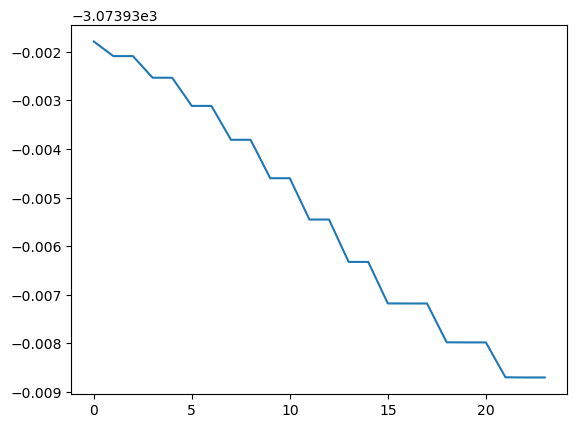

In [48]:
# Plot the energy values of backward IRC scan
irc_backward_energies = irc_backward_history['energy']
plt.plot(irc_backward_energies)

In [49]:
# Get the list of coordinates
irc_backward_coordinates_list = irc_backward_history['coordinates']

# Get the number of conformers
print(len(irc_backward_coordinates_list))

24


In [50]:
# Generate the PDB trajectory string
pdb_trajectory = WritePDBTrajectory(ts_optimized_mol, irc_backward_coordinates_list, True, 2.5)

In [51]:
# Show the animation
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(pdb_trajectory, "trajectory", {'keepH': True})
view.setBackgroundColor('white')
view.setStyle({'stick': {'scale': 0.3}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.animate({'loop': "forward", 'interval': 200}) # Adjust the speed as needed (set 'interval' to a new value in millisecond)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.